In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Features Tracking and Detection
Features are specific patterns in an image which are unique, can be easily tracked and compared. Corners are usually the best features as they are the regions with large variation in intensity in all directions. They are intutively junctions of contours.

Useful in some vision tasks like stereo and motion estimation, where it's required to find corresponding features across two or more views.

### Harris Corner Detection
Difference in intensity for a displacement of 'x' in x-direction and 'y' in y-direction, in all directions, is given by
$$E(x, y) = \sum_{u}\sum_{v} w(u, v) * [I(u + x, v + y) - I(u, v)]^2$$
- w(u, v) is window function (rectangular or gaussian window which gives weights to pixels underneath, its used for the convolution).
- I(u, v) is intensity of pixel located at coordinate (x, y)

E(u, v) is maximized to detect corners.
$$\text{Let }I_{x}\text{ and }I_{y}\text{ be the partial derivatives of I, I(u + x, v + y) can be approximated using taylor series}$$
$$I(u + x, v + y) \approx I(u, v) + I_{x}(u, v)*x + I_{y}(u, v)*y$$
$$E(x, y) \approx \sum_{u}\sum_{v} w(u, v) * [I_{x}(u, v)*x + I_{y}(u, v)*y]^2$$
Representing the above equation in matrix form
$$E(x, y) \approx \begin{bmatrix}x & y\end{bmatrix} * M\begin{bmatrix}x\\y\end{bmatrix}$$
$$M = \sum_{u, v} w(u, v) * \begin{bmatrix}I_{x}^2 & I_{x}I_{y}\\I_{x}I_{y} & I_{y}^2\end{bmatrix}$$
$$\text{M will have 2 eigen values }\lambda_{1}\text{ and }\lambda_{2}$$

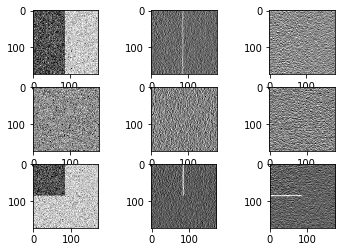

In [2]:
edge = cv2.imread("../resources/harris_1.png", cv2.IMREAD_GRAYSCALE)
edge_x = cv2.Sobel(edge, cv2.CV_64F, 1, 0, ksize=5)
edge_y = cv2.Sobel(edge, cv2.CV_64F, 0, 1, ksize=5)

flat = cv2.imread("../resources/harris_2.png", cv2.IMREAD_GRAYSCALE)
flat_x = cv2.Sobel(flat, cv2.CV_64F, 1, 0, ksize=5)
flat_y = cv2.Sobel(flat, cv2.CV_64F, 0, 1, ksize=5)

corner = cv2.imread("../resources/harris_3.png", cv2.IMREAD_GRAYSCALE)
corner_x = cv2.Sobel(corner, cv2.CV_64F, 1, 0, ksize=5)
corner_y = cv2.Sobel(corner, cv2.CV_64F, 0, 1, ksize=5)

plt.subplot(3, 3, 1)
plt.imshow(edge, cmap='gray')
plt.subplot(3, 3, 2)
plt.imshow(edge_x, cmap='gray')
plt.subplot(3, 3, 3)
plt.imshow(edge_y, cmap='gray')

plt.subplot(3, 3, 4)
plt.imshow(flat, cmap='gray')
plt.subplot(3, 3, 5)
plt.imshow(flat_x, cmap='gray')
plt.subplot(3, 3, 6)
plt.imshow(flat_y, cmap='gray')

plt.subplot(3, 3, 7)
plt.imshow(corner, cmap='gray')
plt.subplot(3, 3, 8)
plt.imshow(corner_x, cmap='gray')
plt.subplot(3, 3, 9)
plt.imshow(corner_y, cmap='gray')

plt.show()

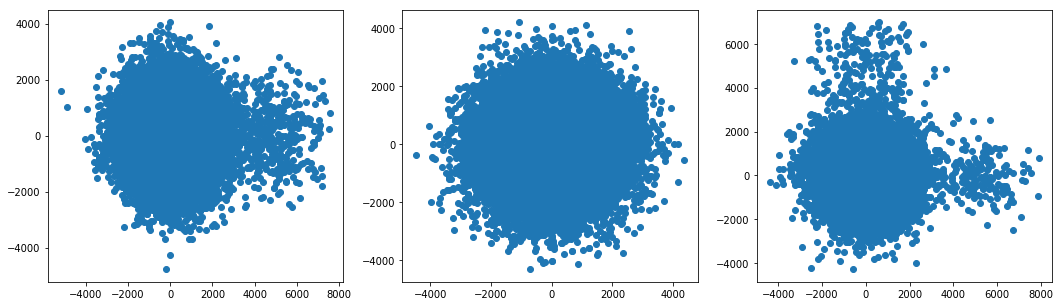

In [3]:
fig = plt.figure()
fig.set_size_inches(18, 5)
fig.add_subplot(1, 3, 1)
plt.scatter(edge_x.flatten(), edge_y.flatten())
fig.add_subplot(1, 3, 2)
plt.scatter(flat_x.flatten(), flat_y.flatten())
fig.add_subplot(1, 3, 3)
plt.scatter(corner_x.flatten(), corner_y.flatten())
plt.show()

Fitting a confidence ellipse around the scatter plot for the above cases, we notice
1. For edge region,
$$\lambda_{1}>>\lambda_{2}\text{ or vice-versa}$$
2. For flat region,
$$\lambda_{1} \approx \lambda_{2}$$
3. For corner region,
$$\lambda_{1} \approx \lambda_{2}\text{ and the eigen values are comparatively larger than those for flat region}$$

Score equation to determine if a window contains a corner: <b>R = det(M) - k(trace(M))<sup>2</sup></b>
$$det(M) = \lambda_{1}\lambda_{2}$$
$$trace(M) = \lambda_{1} + \lambda_{2}$$
- R is small => flat region
- R < 0 => edge region
- R is large => corner region
<img src="../resources/harris.jpg">
Function: <b>cv2.cornerHarris(image, window_block_size, sobel_block_size, k)</b>

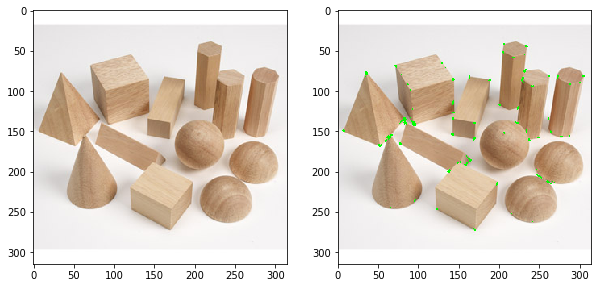

In [4]:
image = cv2.imread("../resources/corner_test.jpg")
copy = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

fig = plt.figure()
fig.set_size_inches(10, 5)
fig.add_subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

corner_regions = cv2.cornerHarris(gray, 3, 3, 0.04)
thresholded_region = corner_regions > 0.01 * corner_regions.max()
# print "Corners: ", image[thresholded_region]
image[thresholded_region] = [0, 255, 0]

fig.add_subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### Refined Corners
Function: <b>cv2.cornerSubPixel(image, corners, winSize, zeroZone, criteria)</b>
- winSize: Half of side length of search window, (3, 3) => (3*2+11 3*2+1) => (7, 7)
- zeroZone: Half of size of dead region in middle of searc window
- criteria: Termination of the iterative process of corner refinement. Stopping parameters => maxCount and epsilon.

With a corner detection algorithm like the Harris corner detector, we end up with a corner like (56, 120). But, sometimes we want a more precise corner like (56.768, 120.1432).

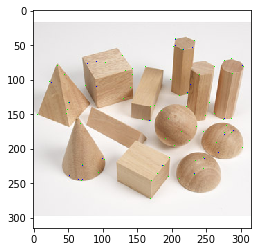

In [5]:
# Refined Corners
# Use of cv2.cornerSubPixel

corner_regions = cv2.dilate(corner_regions, None)
refined_region = cv2.threshold(corner_regions, 0.001 * corner_regions.max(), 255, cv2.THRESH_BINARY)[1]
refined_region = np.uint8(refined_region)

ret, labels, stats, centroids = cv2.connectedComponentsWithStats(refined_region)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000000, 0.0001)
corners = cv2.cornerSubPix(gray, np.float32(centroids), (3, 3), (-1, -1), criteria)

res = np.int0(np.hstack((centroids, corners)))
copy[res[:, 1], res[:, 0]] = [255, 0, 0]
copy[res[:, 3], res[:, 2]] = [0, 255, 0]

plt.imshow(cv2.cvtColor(copy, cv2.COLOR_BGR2RGB))
plt.show()

### Shi-Tomasi Corner Detection
The Shi-Tomasi corner detector is based entirely on the Harris corner detector. However, one slight variation in "selection criteria" made this detector much better than the original. It works quite well where even the Harris corner detector fails.
$$Score (R) = min(\lambda_{1}, \lambda_{2})$$
<img src="../resources/shi-tomasi.jpg">

- <font color="#00FF00">Corner Region</font> $$\text{Both }\lambda_{1}\text{ and }\lambda_{2}\text{ are greater than threshold value}$$
- <font color="#3311FF">Edge <font color="#808080">Region</font></font> $$\text{Either }\lambda_{1}\text{ or }\lambda_{2}\text{ is smaller than threshold value}$$
- <font color="#FF69B4">Flat Region</font>$$\text{Both }\lambda_{1}\text{ and }\lambda_{2}\text{ are less than threshold value}$$

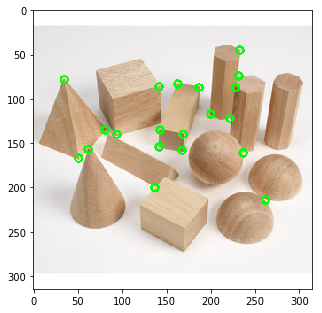

In [6]:
image = cv2.imread("../resources/corner_test.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# cv2.goodFeaturesToTrack(image, number of corners, quality, min euclidean distance)
tomasi_corners = np.int0(cv2.goodFeaturesToTrack(gray, 20, 0.05, 8))
for corner in tomasi_corners:
    x, y = corner.ravel()
    cv2.circle(image, (x, y), 4, (0, 255, 0), 2)

fig = plt.figure()
fig.set_size_inches(5, 10)
fig.add_subplot(1, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()